# Jane Street Game

General Notes
* I can probably do a lot of optimizing to make the simulation code run much faster, but it makes the code harder to understand, so I will stick with my more intuitive, slower versions. 
* Add "strat name" as an input to the strat class.
* Add "results" validator to the class.
  * Check for no nul entries.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 5.5]
rng = np.random.default_rng()

# Set Parameters

In [86]:
ALLOWED_FLIPS = 100
DEFAULT_SIMULATION_COUNT = 1_000

# Probability of getting heads:
COIN_DISTRIBUTIONS = pd.Series({
    'c_1': .5,  # This should always be the fair coin...
    'c_2': .4,
    'c_3': .7,
    'c_4': .3,
    'c_5': .75,
    'c_6': .65,
    'c_7': .8,
    'c_8': .55,
    'c_9': .40,
    'c_10': .60,
})

# We'll also want to reference the subset that excludes the fair coin frequently
UNKNOWN_COINS = COIN_DISTRIBUTIONS.iloc[1:] 

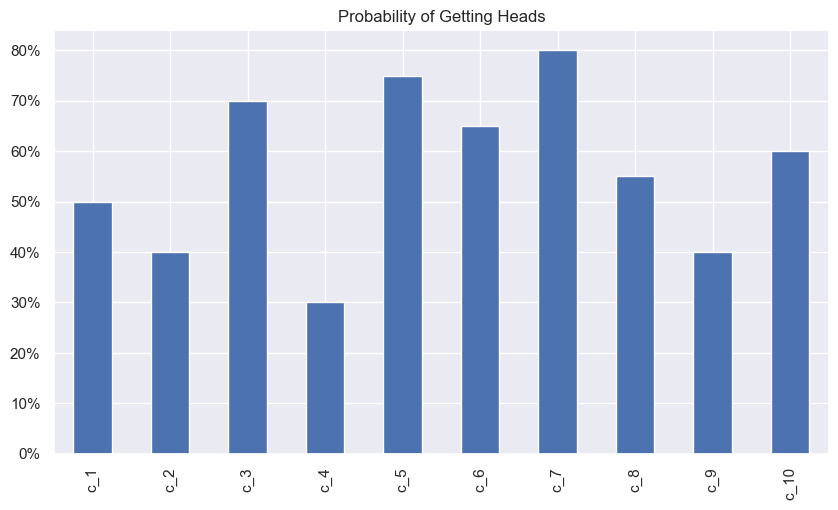

In [87]:
fig, ax = plt.subplots()
COIN_DISTRIBUTIONS.plot(kind='bar', ax=ax)
ax.set_title('Probability of Getting Heads')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'));

# Classes

In [98]:
class StratStats:
    '''Container class to hold the statistics of a strategies results. '''

    chips_won: pd.Series
    expected_winnings: float
    standard_deviation: float
    percentile_5: float
    percentile_95: float
    cvar_5: float


class GameData:

    def __init__(self,flips=ALLOWED_FLIPS) -> None:
        # Whatever it is that we want to store should have matching indexes so that we can easily link them together
        indexes = range(flips)

        # These should be null until populated by the simulation
        self.flip_results = pd.Series(index=indexes, dtype='int') 

        # These will be strings that reference the coin that was chosen for each flip
        self.chosen_coins = pd.Series(index=indexes, dtype='str') 

        # We may want to store our estimates of the probability of each coin as well
        self.estimated_probs = pd.DataFrame(index=indexes, columns=COIN_DISTRIBUTIONS.index)
    
    def plot_decisions(self,tick_interval=10,sort_lables=True):
        '''Plot the x axis as the flip number and the y axis as the coin that was chosen. I want to see the decisions made over time.'''


        if sort_lables:
            # Nitpicky, but sort the data so that the plot shows the coins in ascending order...
            sorted_data = self.chosen_coins.sort_values(key=lambda x: x.str.split('_').str[1].astype(int))

        fig, ax = plt.subplots()

        # Sort the index before plotting
        ax.scatter(sorted_data.index, sorted_data)

        # Show ticks every 5 flips
        ax.set_xticks(range(0,len(sorted_data),tick_interval))

        ax.set_title('Coin Choices Over Time')
        ax.set_xlabel('Flip Number')





class StratAnalyzer:
    def __init__(self, game_data:list[GameData],strat_name='') -> None:
        
        self.game_data = game_data
        self.strat_name = strat_name

        # Convert the results of all of the game data into a single DataFrame. (Is this horribly inefficient???)
        self.game_results_df = pd.concat([game.flip_results for game in game_data], axis=1)
        # self.game_results_df = game_results_df

        self.stats: StratStats = StratStats()
        self.stats_calcuated = False # Flag to indicate if the stats have been calculated yet.


    def plot_distribution(self,bins=None) -> None:
        fig, ax = plt.subplots()
        if bins is not None:
            sns.histplot(self.stats.chips_won, ax=ax,bins=bins,binwidth=1)
        else:
            sns.histplot(self.stats.chips_won, ax=ax,binwidth=1)
        ax.axvline(self.stats.expected_winnings, color='red', linestyle='--', label=f'Expected Winnings: {round(self.stats.expected_winnings,0):.0f}',lw=2)
        ax.axvline(self.stats.percentile_5, color='g',label=f'5/95 Percentile: ({round(self.stats.percentile_5,0)}, {round(self.stats.percentile_95,0)})',lw=2)
        ax.axvline(self.stats.percentile_95,color='g',lw=2)        
        ax.set_xlabel('Chips Won')
        ax.set_title(f'Distribution of Chips Won for strat: "{self.strat_name}" ')
        ax.legend()

    def calculate_stats(self) -> None:
        '''Calculate some of the key statistics of the simulation that we'll want to look for each simulation. '''

        if not self.stats_calcuated:
            self.stats.chips_won = self.game_results_df.sum()
            self.stats.expected_winnings = self.stats.chips_won.mean()
            self.stats.standard_deviation = self.stats.chips_won.std()
            self.stats.percentile_5 = self.stats.chips_won.quantile(.05)
            self.stats.percentile_95 = self.stats.chips_won.quantile(.95)

            # Add a stat for average value given you're in the bottom 5% of outcomes
            self.stats.cvar_5 = self.stats.chips_won[self.stats.chips_won < self.stats.percentile_5].mean()
            self.stats_calcuated = True

    
    def print_stats_summary(self) -> None:
        '''Print some of the key statistics of the simulation that we'll want to look for each simulation. '''

        self.calculate_stats()
        print(f'Expected Winnings: {self.stats.expected_winnings:.2f}')
        print(f'Standard Deviation: {self.stats.standard_deviation:.2f}')
        print(f'5/95 Percentile: ({self.stats.percentile_5:.2f}, {self.stats.percentile_95:.2f})')
        print(f'CVaR 5%: {self.stats.cvar_5:.2f}')
        print(f'Min: {self.stats.chips_won.min()}')
        print(f'Max: {self.stats.chips_won.max()}')


# Functions

In [89]:
def choose_blindly(coin_distributions:pd.Series) -> str:
    '''Random, equally-weighted sample from the coin distributions excluding the fair coin. '''

    return rng.choice(coin_distributions.index)

# Strategies

## Strat 1: Total Blindfold - Always Random Guess

### Run Simulation

In [99]:
s1_game_data = []

for sim in range(DEFAULT_SIMULATION_COUNT):
    game_data = GameData()
    for flip in range(ALLOWED_FLIPS):

        # Choose the coin we want to flip
        chosen_coins = choose_blindly(UNKNOWN_COINS)

        # Simulate the flip
        flip_result = rng.binomial(1, COIN_DISTRIBUTIONS[chosen_coins])

        # Store the results of the flip
        game_data.flip_results[flip] = flip_result
        game_data.chosen_coins[flip] = chosen_coins
    s1_game_data.append(game_data)

# Now store the results of the simulation in a StratAnalyzer object
s1_analyzer = StratAnalyzer(s1_game_data,'Blindly Choose Coin')

### View Results

In [91]:
s1_analyzer.game_results_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
96,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
97,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
98,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


Expected Winnings: 57.41
Standard Deviation: 5.08
5/95 Percentile: (49.00, 66.00)
CVaR 5%: 46.06
Min: 39.0
Max: 72.0


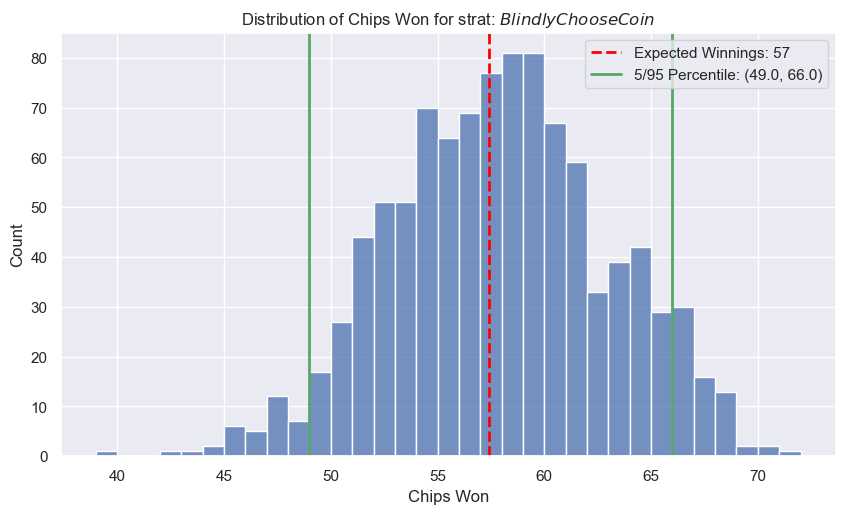

In [100]:
s1_analyzer.print_stats_summary()
s1_analyzer.plot_distribution()

This result makes sense because it's the mean of all the coin's distributions

In [76]:
UNKNOWN_COINS.mean()

0.5722222222222223

Pick a random game and look at the decisions that were made each flip. 

0     c_3
1     c_9
2     c_4
3     c_6
4    c_10
dtype: object

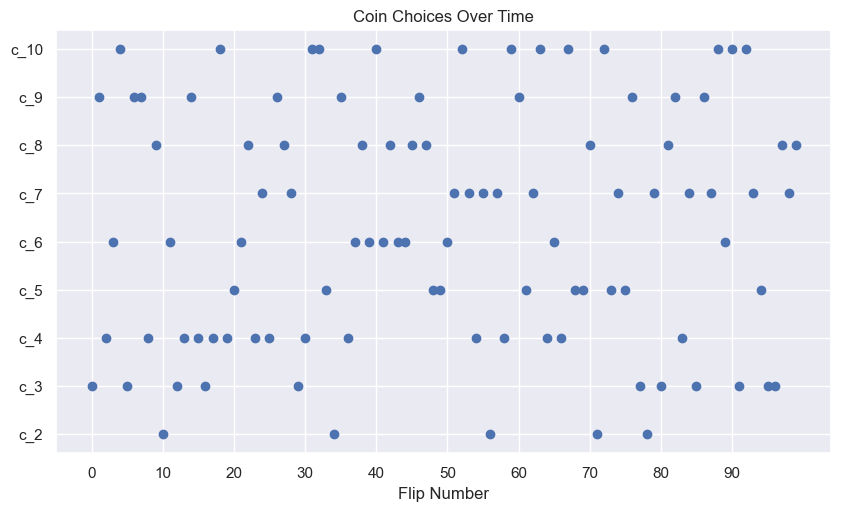

In [84]:
first_game = s1_game_data[0]
display(first_game.chosen_coins.iloc[:5]) # Just to validate that it matches...
first_game.plot_decisions()

## Strat 2: Always Choose Fair Coin

In [ ]:
s2_game_data = []
for sim in range(DEFAULT_SIMULATION_COUNT):
    game_data = GameData()
    # Just Simulate always choosing the fair coin...
    flips = rng.binomial(1, COIN_DISTRIBUTIONS['c_1'], size=ALLOWED_FLIPS)
    game_data.flip_results = flips
    game_data.chosen_coins = 'c_1'
    s2_game_data.append(game_data)

s2_analyzer = StratAnalyzer(s2_game_data)
s2_analyzer.print_stats_summary()


In [26]:

def run_simulations(choose_coin_func:callable, coin_distributions:pd.Series,simulation_count:int=DEFAULT_SIMULATION_COUNT) -> pd.DataFrame:

    # game_results_df = pd.DataFrame(index=range(NUMBER_OF_FLIPS),columns=range(simulation_count))
    game_results = np.zeros((ALLOWED_FLIPS, simulation_count))

    for sim in range(simulation_count):
        for flip in range(ALLOWED_FLIPS):
            chosen_coin = choose_coin_func(coin_distributions)
            flip_result = rng.binomial(1, coin_distributions[chosen_coin])
            game_results[flip,sim] = flip_result
    game_results_df = pd.DataFrame(game_results)
    return game_results_df


# game_results_df = run_simulations(choose_fair_coin, coin_distributions)
game_results_df = run_simulations(choose_fair_coin, coin_distributions, simulation_count=10_000)
fair_coin_strat = StratAnalyzer(game_results_df)
fair_coin_strat.print_summary()

Expected Winnings: 50.02
Standard Deviation: 4.99
95% CI: (42.00, 58.00)
Min: 30.0
Max: 68.0


In [27]:
# fair_coin_strat.chips_won.value_counts().plot(kind='bar')
# fair_coin_strat.chips_won.value_counts()

Expected Winnings: 50.02
Standard Deviation: 4.99
95% CI: (42.00, 58.00)
Min: 30.0
Max: 68.0


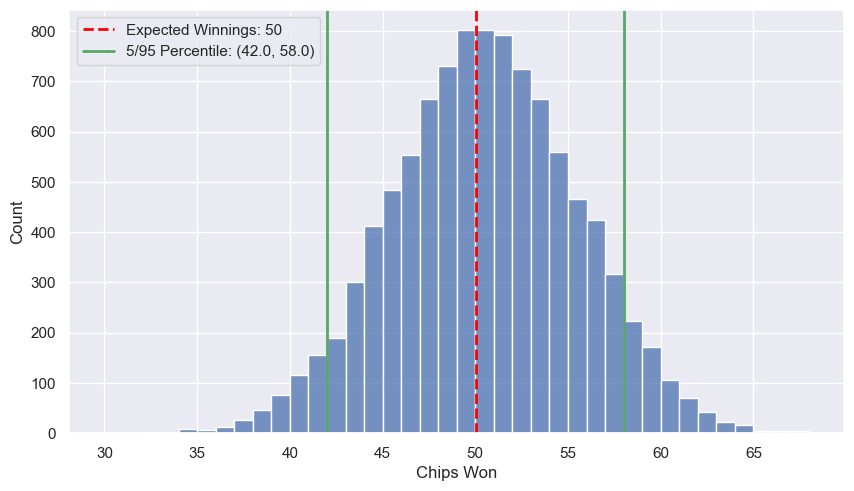

In [28]:
fair_coin_strat.plot_distribution()
fair_coin_strat.print_summary()

# Strat: Pick Random & Commit

In [29]:
# random_commit_results_df

simulation_count = DEFAULT_SIMULATION_COUNT
simulation_count = 100_000
random_commit_results_df = np.zeros((ALLOWED_FLIPS, simulation_count))
for sim in range(simulation_count):
    # Choose the coin we want to commit to
    chosen_coins = choose_blindly(coin_distributions)
    # Simulate 100 flips of that coin.
    simulated_flips = rng.binomial(1, coin_distributions[chosen_coins],ALLOWED_FLIPS)
    random_commit_results_df[:,sim] = simulated_flips

random_commit_results_df = pd.DataFrame(random_commit_results_df)
random_commit_strat = StratAnalyzer(random_commit_results_df)
random_commit_strat.print_summary()

Expected Winnings: 56.44
Standard Deviation: 16.35
95% CI: (30.00, 81.00)
Min: 15.0
Max: 93.0


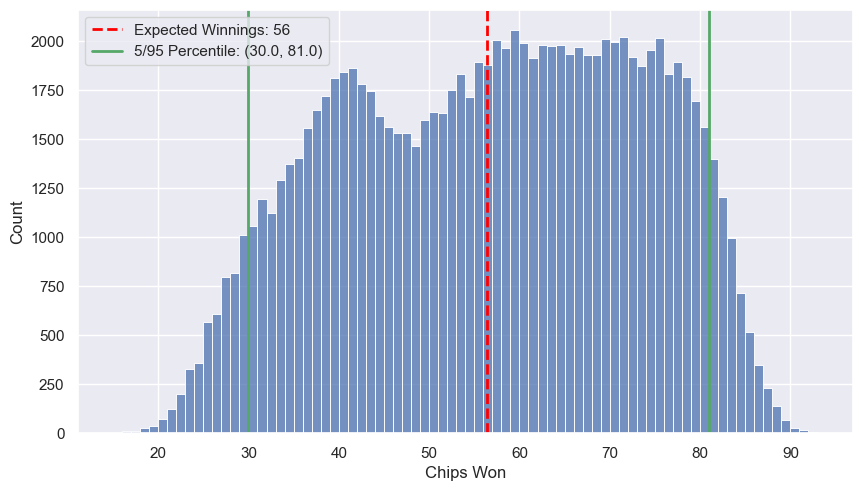

In [30]:
random_commit_strat.plot_distribution()

# Strats: Search & Exploit

## SE1: Seach & Big Commit

In [31]:
def get_max_prob_coin_random(estimated_coin_prob:dict) -> str:
    '''Return the maximum probability coin. If multiple coins have the same probability, choose randomly.'''
    max_prob = max(estimated_coin_prob.values())
    max_prob_coins = [coin for coin, prob in estimated_coin_prob.items() if prob == max_prob]
    random_coin = rng.choice(max_prob_coins)
    return random_coin

In [32]:
# random_commit_results_df
simulation_count = DEFAULT_SIMULATION_COUNT
simulation_count = 10_000
SEARCH_FLIPS = 5 # Budget around half my flips to data collection
se1_results_df = np.zeros((ALLOWED_FLIPS, simulation_count))
search_coins = coin_distributions.iloc[1:] # Search coins are all coins except the fair coin
for sim in range(simulation_count):
    

    estimated_coin_probs = {'c_1':.5} # This will store our estimates of the probability for each coin
    for i in range(len(search_coins)):
        # Simulate x flips of that coin.
        actual_prob = search_coins.iloc[i]
        coin_label = search_coins.index[i]
        flip_counter = rng.binomial(1, actual_prob, SEARCH_FLIPS)
        estimated_coin_probs[coin_label] = flip_counter.mean()

        # Store the results of these flips in the results df
        se1_results_df[(i)*SEARCH_FLIPS:(i+1)*SEARCH_FLIPS,sim] = flip_counter
    
    # Pick the coin with the highest estimated probability, including the fair coin
    chosen_coins = get_max_prob_coin_random(estimated_coin_probs)
    # Simulate the rest of the flips with that coin
    flips_left = ALLOWED_FLIPS - len(search_coins)*SEARCH_FLIPS
    simulated_flips = rng.binomial(1, coin_distributions[chosen_coins],flips_left)
    se1_results_df[len(search_coins)*SEARCH_FLIPS:,sim] = simulated_flips


se1_results_df = pd.DataFrame(se1_results_df)
se1_strat = StratAnalyzer(se1_results_df)
se1_strat.print_summary()

Expected Winnings: 64.89
Standard Deviation: 6.80
95% CI: (52.00, 75.00)
Min: 35.0
Max: 86.0


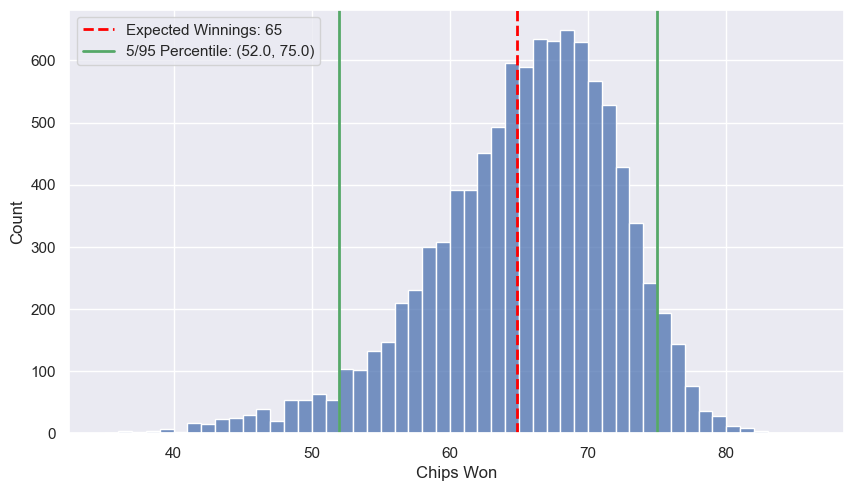

In [33]:
se1_strat.plot_distribution()

## SE2: Continual Prob Eval

In [34]:
def create_data_container(coin_distributions:pd.Series) -> dict:
    data = {'c_1':{'prob':.5,'flip_count':0,'num_heads':0}} 
    for coin in coin_distributions.index[1:]:
        data[coin] = {'prob':np.NaN,'flip_count':0,'num_heads':0}
    return data

# create_data_container(coin_distributions)

Expected Winnings: 66.44
Standard Deviation: 5.12
95% CI: (58.00, 75.00)
Min: 46.0
Max: 83.0


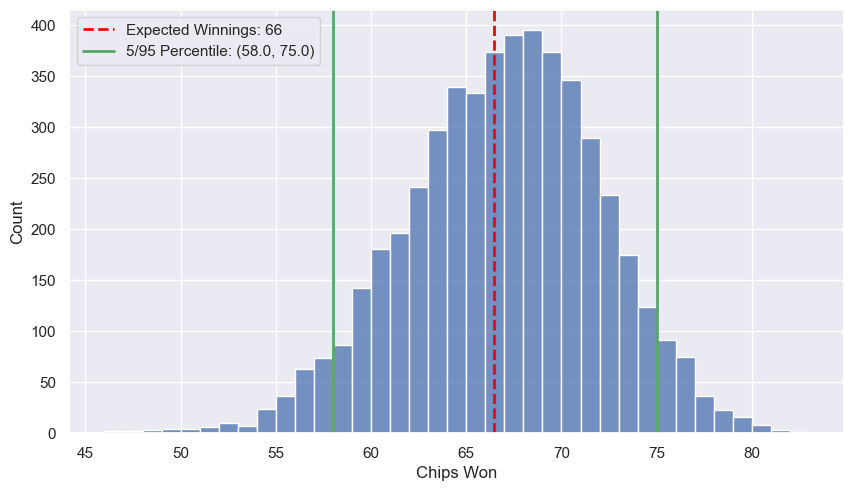

In [47]:
# random_commit_results_df
simulation_count = DEFAULT_SIMULATION_COUNT
simulation_count = 5000
SEARCH_FLIPS = 5 # Budget around half my flips to data collection
se2_results_df = np.zeros((ALLOWED_FLIPS, simulation_count))
search_coins = coin_distributions.iloc[1:] # Search coins are all coins except the fair coin
for sim in range(simulation_count):
    data = create_data_container(coin_distributions)

    for i in range(len(search_coins)):
        actual_prob = search_coins.iloc[i]
        coin_label = search_coins.index[i]
        flip_counter = rng.binomial(1, actual_prob, SEARCH_FLIPS)
        # Store the data in the data container
        data[coin_label]['flip_count'] += SEARCH_FLIPS
        data[coin_label]['num_heads'] += flip_counter.sum()
        data[coin_label]['prob'] = flip_counter.mean()

        # Store the results of these flips in the results df
        se2_results_df[(i)*SEARCH_FLIPS:(i+1)*SEARCH_FLIPS,sim] = flip_counter
    
    # Loop through the rest of my flips. Each time, flip the highest estimated probablility coin. After flipping, update the estimated probability of that coin.
    flips_left = ALLOWED_FLIPS - len(search_coins)*SEARCH_FLIPS
    for flip in range(len(search_coins)*SEARCH_FLIPS,ALLOWED_FLIPS):
        estimated_coin_probs = {coin:data[coin]['prob'] for coin in data}
        chosen_coins = get_max_prob_coin_random(estimated_coin_probs)
        simulated_flip = rng.binomial(1, coin_distributions[chosen_coins])
        # Update the data container
        data[chosen_coins]['num_heads'] += simulated_flip
        data[chosen_coins]['flip_count'] += 1
        # Update the estimated probability of the chosen coin, unless it is the fair coin
        if chosen_coins != 'c_1':
            data[chosen_coins]['prob'] = data[chosen_coins]['num_heads']/data[chosen_coins]['flip_count']
        se2_results_df[flip,sim] = simulated_flip


se2_results_df = pd.DataFrame(se2_results_df)
se2_strat = StratAnalyzer(se2_results_df)
se2_strat.print_summary()
se2_strat.plot_distribution()

## SE3: Optimal Coin Budget?
Find the "best" coin budget to use during the search process. Best is defined as the budget that provides the highest expected value.

In [36]:
SIMS_PER_BUDGET = 4000
budgets = range(1,11) # Budgets from 1 to 10
overall_results = {}
search_coins = coin_distributions.iloc[1:] # Search coins are all coins except the fair coin

for budget in budgets:
    results_df = np.zeros((ALLOWED_FLIPS, SIMS_PER_BUDGET))
    for sim in range(SIMS_PER_BUDGET):
        data = create_data_container(coin_distributions)

        for i in range(len(search_coins)):
            actual_prob = search_coins.iloc[i]
            coin_label = search_coins.index[i]
            flip_counter = rng.binomial(1, actual_prob, budget)
            # Store the data in the data container
            data[coin_label]['flip_count'] += budget
            data[coin_label]['num_heads'] += flip_counter.sum()
            data[coin_label]['prob'] = flip_counter.mean()

            # Store the results of these flips in the results df
            results_df[(i)*budget:(i+1)*budget,sim] = flip_counter

        # Loop through the rest of my flips. Each time, flip the highest estimated probablility coin. After flipping, update the estimated probability of that coin.
        flips_left = ALLOWED_FLIPS - len(search_coins)*budget
        for flip in range(len(search_coins)*budget,ALLOWED_FLIPS):
            estimated_coin_probs = {coin:data[coin]['prob'] for coin in data}
            chosen_coins = get_max_prob_coin_random(estimated_coin_probs)
            simulated_flip = rng.binomial(1, coin_distributions[chosen_coins])
            # Update the data container
            data[chosen_coins]['num_heads'] += simulated_flip
            data[chosen_coins]['flip_count'] += 1
            # Update the estimated probability of the chosen coin, unless it is the fair coin
            if chosen_coins != 'c_1':
                data[chosen_coins]['prob'] = data[chosen_coins]['num_heads']/data[chosen_coins]['flip_count']
            results_df[flip,sim] = simulated_flip

    results_df = pd.DataFrame(results_df)
    strat = StratAnalyzer(results_df)
    overall_results[budget] = strat


In [37]:
df_results = pd.DataFrame()
df_results['expected_winnings'] = [overall_results[budget].expected_winnings for budget in overall_results]
df_results['standard_deviation'] = [overall_results[budget].standard_deviation for budget in overall_results]
df_results['percentile_2_5'] = [overall_results[budget].percentile_5 for budget in overall_results]
df_results['percentile_97_5'] = [overall_results[budget].percentile_95 for budget in overall_results]
df_results['min'] = [overall_results[budget].chips_won.min() for budget in overall_results]
df_results['max'] = [overall_results[budget].chips_won.max() for budget in overall_results]
df_results['sharpe'] = df_results['expected_winnings']/df_results['standard_deviation']
df_results.index = budgets
df_results

,expected_winnings,standard_deviation,percentile_2_5,percentile_97_5,min,max,sharpe
1,70.92975,7.075933,58.0,81.0,34.0,87.0,10.024084
2,70.30175,6.368268,59.0,79.0,38.0,88.0,11.039383
3,69.25300,5.809727,59.0,78.0,40.0,85.0,11.920181
4,67.85475,5.533878,59.0,77.0,40.0,83.0,12.261699
5,66.37300,5.249787,57.0,75.0,39.0,84.0,12.642990
6,64.94200,4.982955,56.0,73.0,42.0,81.0,13.032828
7,63.54300,4.869043,55.0,71.0,46.0,80.0,13.050409
8,62.16000,4.704831,54.0,70.0,46.0,77.0,13.211952
9,60.49425,4.710840,53.0,68.0,36.0,78.0,12.841499
10,58.93100,4.584048,51.0,67.0,42.0,74.0,12.855669


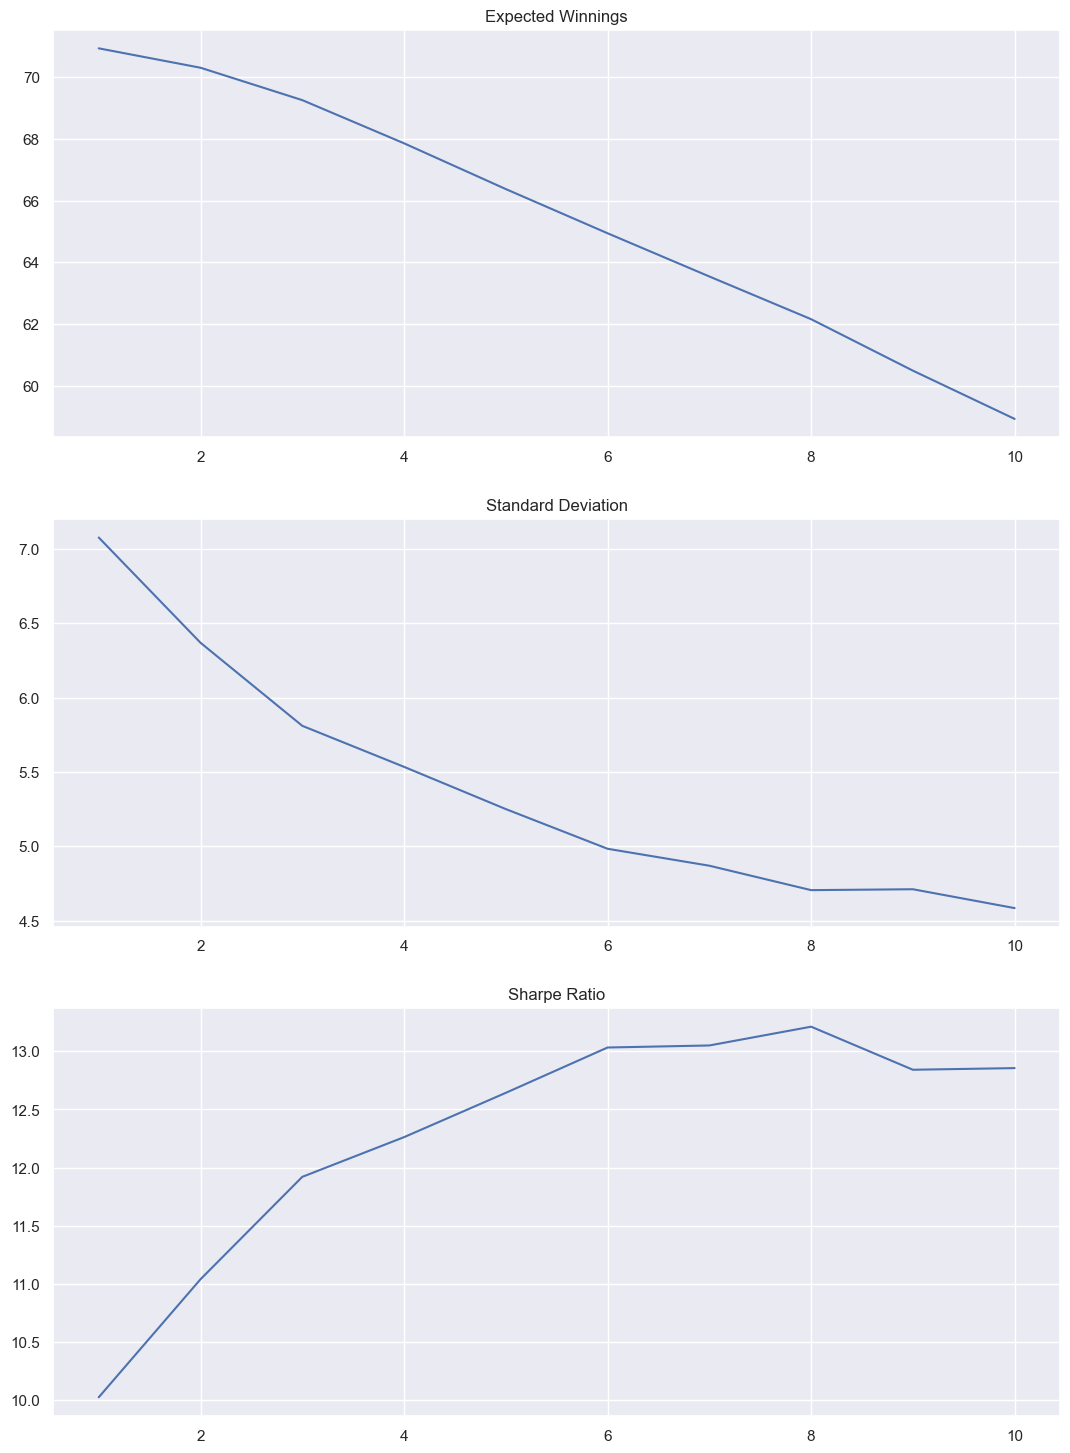

In [38]:
# Same plot as above, but each on their own plot
fig, ax = plt.subplots(3,1,figsize=(13,18))
df_results['expected_winnings'].plot(ax=ax[0], label='Expected Winnings')
df_results['standard_deviation'].plot(ax=ax[1], label='Standard Deviation')
df_results['sharpe'].plot(ax=ax[2], label='Sharpe Ratio')
ax[0].title.set_text('Expected Winnings')
ax[1].title.set_text('Standard Deviation')
ax[2].title.set_text('Sharpe Ratio');

8
Expected Winnings: 62.16
Standard Deviation: 4.70
95% CI: (54.00, 70.00)
Min: 46.0
Max: 77.0


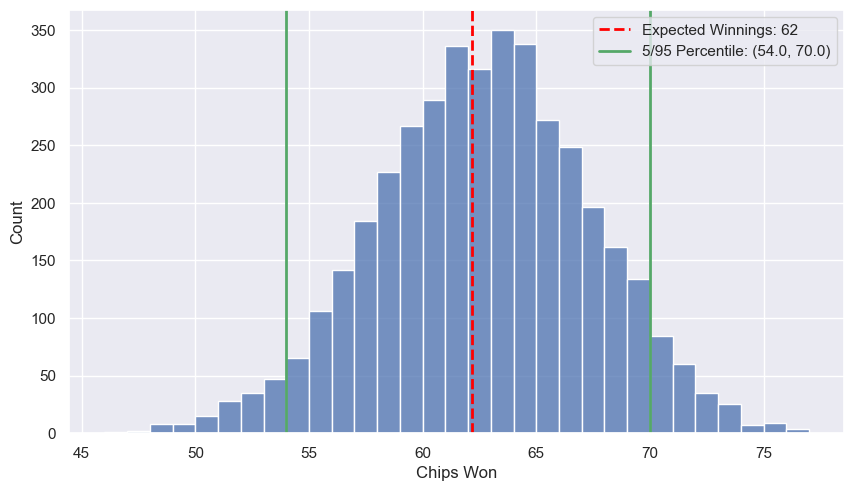

In [39]:
best_strat = max(overall_results, key=lambda x: overall_results[x].expected_winnings)
best_strat = max(overall_results, key=lambda x: overall_results[x].expected_winnings / overall_results[x].standard_deviation)
print(best_strat)
overall_results[best_strat].print_summary()
overall_results[best_strat].plot_distribution()

## SE4: Sam's Method
Flip each coin, until we get tails. Then exploit: always picking highest estimated prob.

Expected Winnings: 69.07
Standard Deviation: 5.93
95% CI: (59.00, 78.00)
Min: 45.0
Max: 83.0


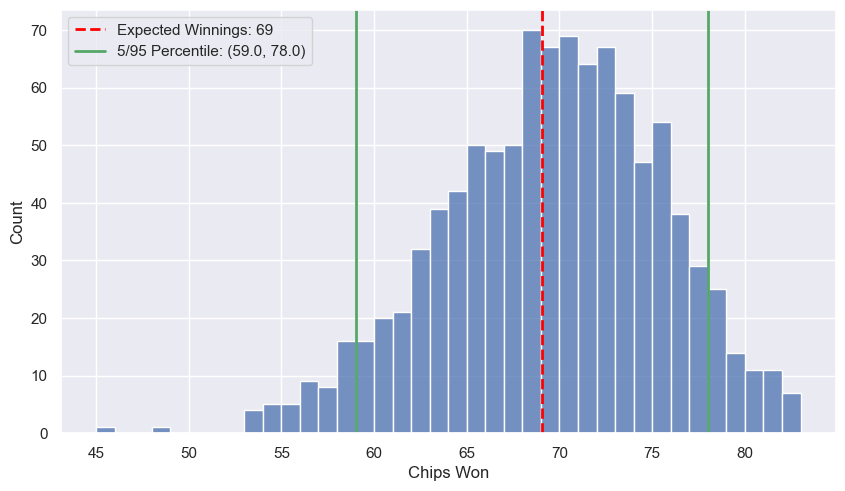

In [48]:
simulation_count = DEFAULT_SIMULATION_COUNT
simulation_count = 1_000
# Create the results df, but make the default option nulls this time
results_df = np.zeros((ALLOWED_FLIPS, simulation_count)) *  np.nan
search_coins = coin_distributions.iloc[1:] # Search coins are all coins except the fair coin
MIN_FLIPS = 3



for sim in range(simulation_count):
    data = create_data_container(coin_distributions)
    flip_counter = 0
    # Continue "Exploring Coins" until we have hit tails and have hit our min flips for that coin
    not_explored = list(search_coins.index)
    while len(not_explored) > 0:

        # Randomly choose a coin to explore
        chosen_coins = rng.choice(not_explored)
        not_explored.remove(chosen_coins)
        # Keep flipping until we hit tails or we have hit our min flips for that coin
        while (data[chosen_coins]['num_heads'] == data[chosen_coins]['flip_count']) or  (data[chosen_coins]['flip_count'] < MIN_FLIPS) :
            flip = rng.binomial(1, coin_distributions[chosen_coins])
            data[chosen_coins]['flip_count'] += 1
            data[chosen_coins]['num_heads'] += flip
            results_df[flip_counter,sim] = flip
            flip_counter += 1
            # if The flips ever exceed the number of flips, break out of all loops
            if flip_counter >= ALLOWED_FLIPS:
                print('Breaking!!')
                print(flip_counter,not_explored)
        
    # Now that we have explored all coins in a smart way, we can flip the one with highest probability
    # Update the probablilities of each coin
    for coin in data:
        if coin != 'c_1':
            data[coin]['prob'] = data[coin]['num_heads']/data[coin]['flip_count']


    flips_left = ALLOWED_FLIPS - flip_counter
    for i in range(flip_counter,ALLOWED_FLIPS):
        estimated_coin_probs = {coin:data[coin]['prob'] for coin in data if coin != 'c_1'}
        chosen_coins = get_max_prob_coin_random(estimated_coin_probs)
        flip = rng.binomial(1, coin_distributions[chosen_coins])
        results_df[i,sim] = flip
        data[chosen_coins]['flip_count'] += 1
        data[chosen_coins]['num_heads'] += flip
        if chosen_coins != 'c_1':
            data[chosen_coins]['prob'] = data[chosen_coins]['num_heads']/data[chosen_coins]['flip_count']
            

results_df = pd.DataFrame(results_df)
se4_strat = StratAnalyzer(results_df)
se4_strat.print_summary()
se4_strat.plot_distribution()


In [41]:
estimated_coin_probs
data

{'c_1': {'prob': 0.5, 'flip_count': 0, 'num_heads': 0},
 'c_2': {'prob': 0.0, 'flip_count': 1, 'num_heads': 0},
 'c_3': {'prob': 0.5, 'flip_count': 2, 'num_heads': 1},
 'c_4': {'prob': 0.0, 'flip_count': 1, 'num_heads': 0},
 'c_5': {'prob': 0.6666666666666666, 'flip_count': 3, 'num_heads': 2},
 'c_6': {'prob': 0.5, 'flip_count': 2, 'num_heads': 1},
 'c_7': {'prob': 0.8571428571428571, 'flip_count': 84, 'num_heads': 72},
 'c_8': {'prob': 0.75, 'flip_count': 4, 'num_heads': 3},
 'c_9': {'prob': 0.0, 'flip_count': 1, 'num_heads': 0},
 'c_10': {'prob': 0.5, 'flip_count': 2, 'num_heads': 1}}